In [113]:
import pandas as pd
import datetime as dt
import json

In [102]:
path = '../network_read/hist_data/2022-04-16/AQU/4'
path_parts = path.split('/')
date = path_parts[-3]
track_id = path_parts[-2]
race_number = path_parts[-1]
race_dt = dt.datetime.strptime(date, '%Y-%m-%d')

pd.set_option('display.max_columns', None)

In [103]:
details = pd.read_csv(f'{path}/details.csv')

In [104]:
bis = pd.read_csv(f'{path}/bis.csv')

In [105]:
# Remove scratched
bis = bis[bis['scratched'] == False]

check_for_nans = ['powerRating','daysOff','horseWins','horseStarts','avgClassRating','highSpeed','avgSpeed','lastClassRating',
                  'avgDistance','numRaces','early','middle','finish','starts','wins','places','shows','finishPosition',
                  ]
for col in check_for_nans:
    if bis[col].isna().sum() != 0:
        # (TODO) return (skip this race)
        pass

bis.loc[:,'age'] = race_dt.year - bis.loc[:,'birthday']
bis.loc[:,'winPayoff'] = bis.loc[:,'winPayoff'] / bis.loc[:,'betAmount']
bis.loc[:,'placePayoff'] = bis.loc[:,'placePayoff'] / bis.loc[:,'betAmount']
bis.loc[:,'showPayoff'] = bis.loc[:,'showPayoff'] / bis.loc[:,'betAmount']

# for horseName, jockey, trainer, owner, sire, damSire, dam. keep them for now. later, find which ones are most common and one-hot on those.

to_keep = [#'runnerId',
           'horseName','jockey','trainer','owner','weight','sire','damSire','dam','age','sex','powerRating',
           'daysOff','horseWins','horseStarts','avgClassRating','highSpeed','avgSpeed','lastClassRating','avgDistance',
           'finishPosition']
bis = bis[to_keep]

In [106]:
bis

,horseName,jockey,trainer,owner,weight,sire,damSire,dam,age,sex,powerRating,daysOff,horseWins,horseStarts,avgClassRating,highSpeed,avgSpeed,lastClassRating,avgDistance,finishPosition
0,Alms,Castellano Javier,Stidham Michael,"Godolphin, LLC",118,City Zip,Empire Maker,Charity Belle,5,M,101.1,41,2,8,105.0,105.0,96.0,106.0,97.0,4.0
2,Plum Ali,Franco Manuel,Clement Christophe,"Dubb, Michael, Madaket Stables LLC and Caruso,...",120,First Samurai,Stroll,Skipping,4,F,107.3,152,4,11,110.0,111.0,101.0,111.0,98.0,1.0
4,Flower Point,Lezcano Jose,Mcgaughey Iii Claude R,"Feiger, Steve",120,Point Of Entry,Lewis Michael,Fab Flowers,6,M,103.6,140,1,4,101.0,104.0,96.0,104.0,100.0,3.0
5,Technical Analysis (Ire),Davis Dylan,Brown Chad C,"Klaravich Stables, Inc.",123,Kingman (Gb),Sea The Stars (Ire),Sealife (Ire),4,F,106.3,181,4,7,95.0,106.0,95.0,113.0,93.0,2.0


In [107]:
dist_to_meters = {'f': 201.168,
                  'mtr': 1,     # mtr (meter) comes before m (mile) in search
                  'm': 1609.34,
                  'y': 0.9144}
details.loc[0,'distance'] = details.loc[0,'distance'] * dist_to_meters[details.loc[0,'distance_unit'].lower()]

In [108]:
details = details[['distance','surface_name','race_type_code','race_class']]

In [115]:
bis_list = bis.to_dict('records')
for idx, bi in enumerate(bis_list):
    details.loc[0,f'bi{idx}'] = json.dumps(bi)


In [116]:
details

,distance,surface_name,race_type_code,race_class,bi0,bi1,bi2,bi3
0,1609.344,Turf,T,Stakes,"{""horseName"": ""Alms"", ""jockey"": ""Castellano Ja...","{""horseName"": ""Plum Ali"", ""jockey"": ""Franco Ma...","{""horseName"": ""Flower Point"", ""jockey"": ""Lezca...","{""horseName"": ""Technical Analysis (Ire)"", ""joc..."


## data_hist

In [120]:
import numpy as np
import pandas as pd
import os
import itertools
import matplotlib.pyplot as plt
import json
from collections import defaultdict

In [162]:
horseracing_path = f'./'

data = pd.read_csv(horseracing_path + 'hist_data.csv', header=None)
num_horses = 10

In [165]:
def extract_dict(dict_str):
    try:
        return json.loads(dict_str)
    except:
        return None
def get_uniques(df, bi_feature, threshold=1):
    uniques = defaultdict(lambda: 0)
    for r in range(df.shape[0]):
        for c in range(4,df.shape[1]):
            d = extract_dict(df.iloc[r,c])
            if d == None:
                continue
            uniques[d[bi_feature]] += 1
    threshold_uniques = {k:v for k,v in uniques.items() if v >= threshold}
    return {k: v for k, v in sorted(threshold_uniques.items(), key=lambda x: -x[1])}

In [167]:
get_uniques(data, 'horseName', 10)

{'Intervention': 13,
 'Abnaa': 12,
 'Coase': 12,
 'Soyounique (Ire)': 10,
 'Out For Justice': 10,
 'Beverly Park': 10}

In [169]:
get_uniques(data, 'jockey', 300)

{'Gaffalione Tyler': 412,
 'Saez Luis': 394,
 'Hernandez Harry': 355,
 'Gomez Jose A': 345,
 'Herrera Diego A': 332,
 'Ortiz, Jr. Irad': 324,
 'Leon Sonny': 312,
 'Ortiz Jose L': 312,
 'Alvarado Junior': 312,
 'Camacho Samy': 305,
 'Davis Dylan': 301,
 'Mccarthy Trevor': 301}

In [172]:
get_uniques(data, 'owner', 100)

{'Bruno Schickedanz': 161,
 'Hollywood Syndicate (Nom: Mr A Delpech)': 135,
 'Edward C. Allred': 129,
 'End Zone Athletics, Inc.': 121,
 'End Zone Athletics Inc. (Karl Broberg and Matt Johanson)': 119,
 'Steve F. Williams': 116,
 'Mark N. Hibdon': 103,
 'Danny R. Caldwell': 101}

In [175]:
get_uniques(data, 'dam', 15)

{'Culotte': 18,
 'Celestial Being': 18,
 'Ready Reply': 16,
 'Katie Katella': 16,
 'Along Came Casey (Ire)': 16,
 "Jimmy's Jewel": 15,
 "Sara's Smile": 15,
 'Guanahani': 15,
 'Cabo Sunrise': 15,
 'Arealhotlover': 15,
 'April Eyes': 15,
 'Restless Summer': 15,
 'Miss Silky Cat': 15,
 'Royal Grand Slam': 15}

In [178]:
get_uniques(data, 'damSire', 500)

{nan: 2635,
 "Unbridled's Song": 686,
 'Malibu Moon': 624,
 "Giant's Causeway": 620,
 'Smart Strike': 581,
 'Tapit': 575,
 'Tiznow': 567,
 'Distorted Humor': 541,
 "Medaglia D'oro": 502}

In [181]:
get_uniques(data, 'sire', 300)

{'Into Mischief': 442,
 'Munnings': 388,
 'Goldencents': 361,
 'Hard Spun': 339,
 'Cairo Prince': 336,
 'Twirling Candy': 336,
 'Tapiture': 326,
 'Street Sense': 317,
 'Congrats': 316,
 'Violence': 309,
 'Exaggerator': 302,
 'Creative Cause': 302,
 'Quality Road': 302}

In [183]:
get_uniques(data, 'trainer', 200)

{'Asmussen Steven M': 640,
 'Broberg Karl': 436,
 'Wong Jonathan': 418,
 'Ness Jamie': 276,
 'Maker Michael J': 257,
 'Diodoro Robertino': 235,
 'Farrior Anthony': 227,
 'Casse Mark E': 224,
 'P. A. Peter, South Africa': 208,
 'Pletcher Todd A': 206,
 'Joseph, Jr. Saffie A': 206,
 'Cox Brad H': 205}

# start time vs post time

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('./start_times.csv')
df['recording_start_time'] = df['recording_start_time'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
df['race_start_time'] = df['race_start_time'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
df['post_time'] = df['post_time'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))

In [6]:
df.head()

,date,track_id,race_number,recording_start_time,race_start_time,post_time
0,2022-04-29,CHT,7,2022-04-29 01:59:10.063108,2022-04-29 02:12:07.680658,2022-04-30 02:02:00
1,2022-04-29,CHT,6,2022-04-29 01:29:07.908056,2022-04-29 01:43:20.856322,2022-04-30 01:32:00
2,2022-04-29,CHT,1,2022-04-29 22:55:12.899085,2022-04-29 23:10:37.664410,2022-04-29 23:00:00
3,2022-04-29,CHT,8,2022-04-29 02:28:11.209709,2022-04-29 02:43:09.556804,2022-04-30 02:32:00
4,2022-04-29,CHT,4,2022-04-29 00:27:18.574790,2022-04-29 00:43:03.496013,2022-04-30 00:32:00


In [19]:
def plot_diffs(df):
    recording_start_diff = df['race_start_time'] - df['recording_start_time']
    plt.hist(recording_start_diff.apply(lambda x: x.seconds), bins = np.arange(0,1800,60))
    plt.title('Difference in recording start time vs race start time')
    plt.show()
    
    start_post_diff = df['race_start_time'] - df['post_time']
    plt.hist(start_post_diff.apply(lambda x: x.seconds), bins = np.arange(0,1800,60))
    plt.title('Difference in post time vs actual start time')
    plt.show()
    
    plt.scatter(recording_start_diff, start_post_diff)
    plt.title('recording_start_time vs post_time')
    plt.xlabel('post_time')
    plt.ylabel('recording_start_time')
    plt.show()

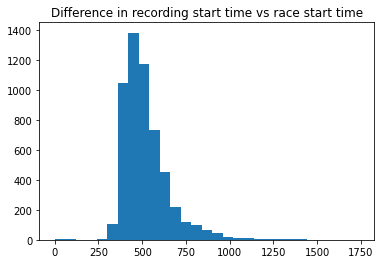

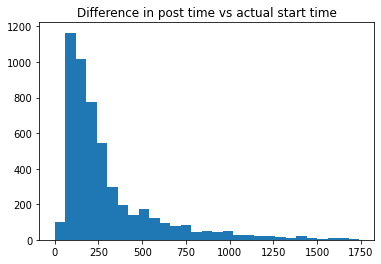

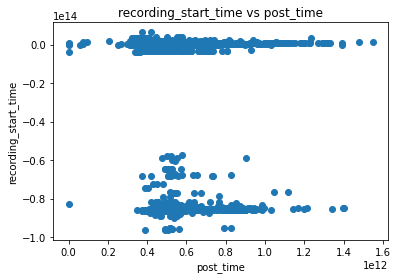

In [20]:
plot_diffs(df)

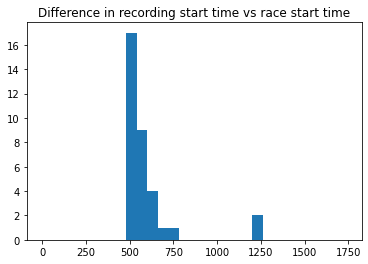

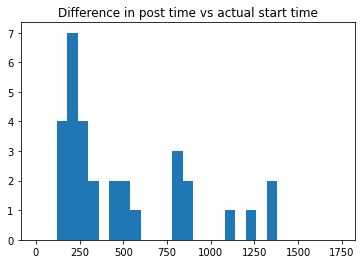

In [14]:
plot_diffs(df[df['track_id'] == 'FP'])

In [21]:
live = pd.read_csv('../../s3_data/v2/2022-06-12/AUC/7/static_bi.csv')

In [22]:
live

,Unnamed: 0,morningLineOdds_numerator,morningLineOdds_denominator,runnerId,winProbability,ratingStars,analystsComments,productionComment,formFigures,freePickNumber,...,winPayoff,placePayoff,showPayoff,beatenDistance,beatenDistanceStatus,isp,postRaceReport,accBeatenDistance,accBeatenDistanceStatus,accBeatenDistanceStatusAbrev
0,1,12,NaN,1,0.0529,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11,2.0,2,0.1154,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,13,2.0,3,0.0976,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2,NaN,4,0.3172,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,15,2.0,5,0.0846,NaN,NaN,NaN,NaN,NaN,...,0.0,6.7,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,7,2.0,6,0.1813,NaN,NaN,NaN,NaN,NaN,...,4.7,2.7,2.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,30,NaN,7,0.0211,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,15,NaN,8,0.0423,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,40,NaN,9,0.0000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,20,NaN,10,0.0317,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
takeouts = pd.read_csv('takeout_estimates_s3.csv')

In [6]:
takeouts[takeouts.iloc[:,0]=='1DD'].iloc[0,1]

0.1630872483221476

In [11]:
import pandas as pd

pd.set_option('display.max_columns', None)

In [26]:
df = pd.read_csv('../network_read/hist_data_v2/2022-05-25/EVD/1/bis.csv')

In [27]:
df

,Unnamed: 0,currentOdds_numerator,currentOdds_denominator,morningLineOdds_numerator,morningLineOdds_denominator,runnerId,scratched,birthday,horseName,jockey,trainer,owner,weight,med,sire,damSire,dam,age,sex,powerRating,daysOff,horseWins,horseStarts,avgClassRating,highSpeed,avgSpeed,lastClassRating,avgDistance,numRaces,early,middle,finish,starts,wins,places,shows,jockeyName,trainerName,runnerNumber,runnerName,finishPosition,betAmount,winPayoff,placePayoff,showPayoff,beatenDistance,beatenDistanceStatus,isp,postRaceReport,accBeatenDistance,accBeatenDistanceStatus,accBeatenDistanceStatusAbrev
0,1,NaN,NaN,2,NaN,1,True,2017,Prissy Jaden,Rodriguez Wallynette,Core Barney,Barney Core and Regina Core,120,L,Wilburn,Sea Hero,Midnight Delight,5,M,46.3,62,0,2,56.0,58.0,42.0,46.0,55.0,3,4.2,2.8,2.9,0,0,0,0,Rodriguez Wallynette,Core Barney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,7.0,NaN,20,NaN,2,False,2018,La Lola,Rivera Josean,Meaux Jason H,"Miguel Cruz, Sr.",120,L,Run Production,Zarbyev,Place Saint Michel,4,F,27.5,41,0,0,40.0,0.0,3.0,41.0,0.0,1,2.7,3.0,8.0,0,0,0,0,Rivera Josean,Meaux Jason H,2.0,La Lola,2.0,2.0,0.0,4.2,0.0,7.25,7¼,8.1,"broke sharp, clear early, pressured pace, no m...",7.25,7 lengths,7.0
2,3,NaN,NaN,12,NaN,3,True,2017,Lawsuit Lucy,Melancon Gerard,Harrison Cortland,Bienvenu Racing (Ellis S. Bienvenu and Peggy W...,120,L,Court Vision,Theatrical (Ire),Elucidate,5,M,28.6,17,0,0,50.0,0.0,36.0,48.0,0.0,10,5.7,4.9,3.2,15,2,2,4,Melancon Gerard,Harrison Cortland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1.0,2.0,9,5.0,4,False,2019,Vancouver Snow,Del-Cid Vicente,Gelner Jayde J,Jayde J. Gelner,113,L,Vancouver (Aus),Fusaichi Pegasus,Cluain Fhada,3,F,35.2,20,0,0,51.0,50.0,41.0,43.0,40.0,2,5.0,4.6,5.3,1,0,1,0,Del-Cid Vicente,Gelner Jayde J,4.0,Vancouver Snow,1.0,2.0,3.0,2.1,0.0,0.00,NaN,1.5,"allowed pace to go, 3w move 2nd turn, edged st...",0.00,NaN,NaN
4,5,6.0,5.0,3,NaN,5,False,2018,Track Queen,Fusilier Casey,Landry Allen,Cool Breeze Racing LLC (Warren and Yana McFatter),120,L,Paynter,Eskendereya,Queen Emma,4,F,31.5,20,0,4,48.0,52.0,29.0,43.0,50.0,2,4.1,3.7,2.6,24,3,1,3,Fusilier Casey,Landry Allen,5.0,Track Queen,3.0,2.0,0.0,0.0,0.0,9.25,9¼,2.2,"chased, pressed middle half, gave way",16.50,17 lengths,17.0
5,6,NaN,NaN,15,NaN,6,True,2019,Secret Moment,Balthazar Jared,Harrison Cortland,Vanessa Camperlengo,118,L,Into Mischief,Fairbanks,Synapse,3,F,25.7,24,0,0,60.0,0.0,9.0,38.0,0.0,1,2.0,7.8,8.9,2,0,0,0,Balthazar Jared,Harrison Cortland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,NaN,NaN,6,NaN,7,True,2018,Resposado,Mcmahon C.J.,Thomas Lee,Elite Thoroughbred Racing LLC (Michelle Rodrig...,120,L,Bind,Kafwain,Sheila Tequila,4,F,43.6,116,0,0,60.0,56.0,36.0,65.0,47.0,4,5.2,5.6,5.4,1,1,0,0,Mcmahon C.J.,Thomas Lee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
